In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import random
import pandas as pd
import yaml
from liftoff import parse_opts
from argparse import Namespace
from experiment_src import *

root_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath("."))))
sys.path.append(root_dir)

from experiment_src import run_sampling_regret_experiment
from experiments.experiment_utils import setup_logger, seed_everything

import logging

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_6196\2067707056.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 5 seeds
# Idea 1: generate all the unique transitions in the MDP, use some for training, some for validation 20% 
# OR, variation 2: select initially some transitions we want in validation, and MOVE them from the training to the validation one
# select probability generated by us with softmax(logits, tau 0.1 or 100) logits: random uniform\
# at each experiment modify tau, decrease it
# Compute the times we select each transition by making numpy choice with probabilities
# take  4000 samples like this: in validation we should have all the possible transitions
# TD learning on training data -> Q, minibatch, for each transition, Stop TD learning when we reach Q* within epsilon
# Calculate Q* and Q train, Q test, and compute regret between them, setup terminal state in corner
# TD learning on validation data -> Q


In [4]:
# fix random policy and do policy evaluation with entire mdp -> Q pi all mdp

# Proposal: replace validation set probabilities with uniform probabilities
# train made with softmax -> Q train done with neural net, fitted policy evaluation with random policy -> td error for random policy
# validation with uniform -> compute belman error (duse Q from train)
# stop Training of neural net -> when we reach the Q pi

In [3]:
# Env settings 
start_state = (0, 0)
terminal_states = {(8, 8): 1.0}
rows, cols = 10, 10
p_success = 1
seed = 0

num_steps = 40_000
lower_bound_softmax = 1.25 / 80
# lower_bound_softmax = 0

# Learning hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.05  # Convergence criterion
tau = 0.1
batch_size = 32
train_max_iterations = 5

np.random.seed(seed)
    
logger = logging.getLogger(__name__)

env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

states = list(set([s for s, _ in env.mdp.keys()]))
actions = list(set([a for _, a in env.mdp.keys()]))
random_policy = create_random_policy(states, actions)

Q = {state: {action: 0 for action in actions} for state in states}
Q_pi_random = random_policy_evaluation_q_stochastic(
    states, actions, random_policy, Q, env.mdp, gamma, epsilon
)

transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
transitions_train, transitions_val = train_test_split(
    transitions_list, test_size=0.2, random_state=seed
)
sampled_transitions_train = generate_transitions_observations(
    transitions_train,
    num_steps,
    tau=tau,
    lower_bound=lower_bound_softmax / len(transitions_train),
)



In [14]:
def generate_random_policy_transitions(transitions_train, num_steps, env):
    np.random.seed(seed)
    transitions = []

    # Convert transitions_train to a set for efficient lookup
    transitions_train_set = {(s, a, ns, r, d): None for s, a, ns, r, d, _ in transitions_train}

    while len(transitions) < num_steps:
        state = env.reset()
        done = False
        while not done:
            action = np.random.choice(actions)
            next_state, reward, done, _, _ = env.step(action)
            transition = (state, action, next_state, reward, done)

            # Only add if the transition is in the transitions_train_set
            if transition[:5] in transitions_train_set:
                transitions.append(transition + (1,)) # adding probability  

            state = next_state
            if len(transitions) >= num_steps:
                break

    return transitions

random_policy_transitions = generate_random_policy_transitions(transitions_train, num_steps, env)
len(random_policy_transitions)

40000

In [13]:
env.step(0)

((0, 0), 0, False, False, {})

In [ ]:
### Training
input_size = len(states[0])  # Or another way to represent the size of your input
output_size = len(actions)

# Initialize the DQN
dqn = DQN(input_size, output_size)

loss_record = train_dqn(
    dqn,
    sampled_transitions_train,
    Q_pi_random,
    states,
    actions,
    gamma,
    epsilon,
    batch_size=batch_size,
    max_iterations=train_max_iterations,
    logger=logger,
)

bm_error = compute_bellmans_error(
    dqn, validation_transitions=transitions_val, gamma=gamma
)

 
# bm_errors_df = pd.DataFrame(bm_errors)
# loss_records_df = pd.DataFrame(loss_records)

In [7]:
# tau = 10
# seed = 0
# loss_record, bm_error = run_sampling_regret_experiment(tau, seed, train_max_iterations=100)
# loss_record[:10]

In [8]:
# # Convert to DataFrame
# df = pd.DataFrame(loss_record, columns=['Iteration', 'Loss', 'ExpectedValue'])

# # Plotting with Seaborn
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='Iteration', y='Loss', marker='o', label='Total Loss')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Loss Curve Over Iterations')
# plt.legend()
# plt.grid(True)
# plt.show()

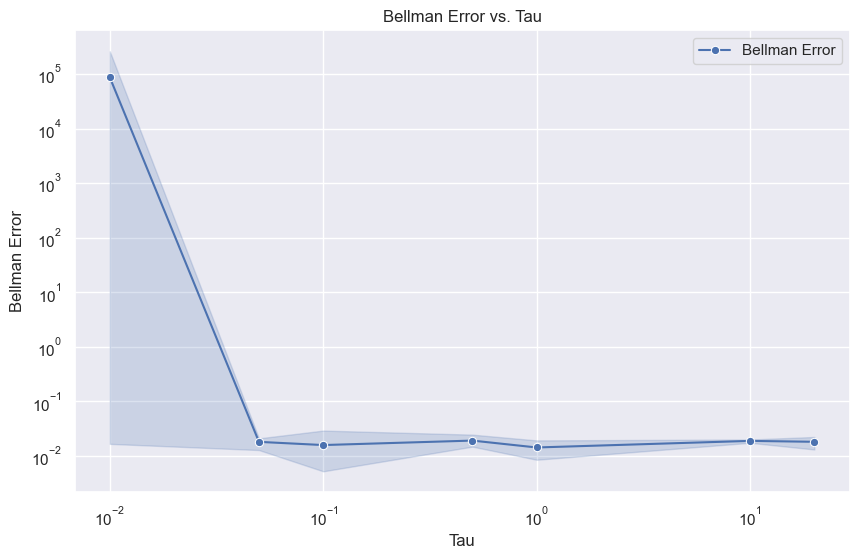

In [27]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=bm_errors_df, x='tau', y='bm_error', marker='o', label='Bellman Error')
plt.xlabel('Tau')
plt.ylabel('Bellman Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Bellman Error vs. Tau')
plt.legend()
plt.show()

In [ ]:
# Try experiment where we have at least 1 time the expected transition and see if now we can reach the large scores (do this by adding lower bound to the softmax)

In [15]:
loss_records_df

,tau,seed,epoch,total_loss,max_diff
0,0.01,0,0,3.107637e+07,8673.152556
1,0.01,0,1,1.897822e+09,53877.588859
2,0.01,0,2,1.751250e+10,145247.213435
3,0.01,0,3,7.892138e+10,265963.743856
4,0.01,0,4,2.112914e+11,416073.483676
...,...,...,...,...,...
10495,20.00,2,495,4.385373e-02,0.429132
10496,20.00,2,496,5.421551e-02,0.412389
10497,20.00,2,497,3.909616e-02,0.445032
10498,20.00,2,498,3.879116e-02,0.466931


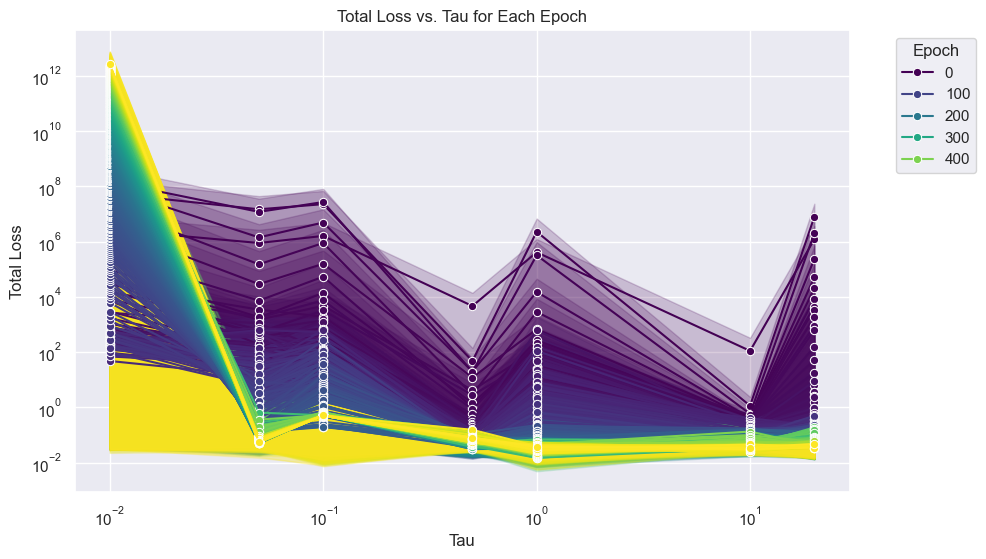

In [28]:
plt.figure(figsize=(10, 6))
# Assuming you want to plot the loss for the last epoch of each run, you can filter or aggregate the data as needed
sns.lineplot(data=loss_records_df, x='tau', y='total_loss', hue='epoch', palette='viridis', marker='o')
plt.xlabel('Tau')
plt.ylabel('Total Loss')
plt.xscale('log')
plt.yscale('log')
plt.title('Total Loss vs. Tau for Each Epoch')
plt.legend(title='Epoch', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [29]:
bm_errors_df.to_csv('res/bm_errors_lowerbound.csv', index=False)  # Save df1 to df1.csv
loss_records_df.to_csv('res/loss_records_lowerbound.csv', index=False)  # Save df2 to df2.csv

### Validating resulting Vs

In [11]:
# # Env settings 
# start_state = (0, 0)
# terminal_states = {(8, 8): 1.0}
# rows, cols = 10, 10
# p_success = 1
# seed = 0

# num_steps = 400_000 # very sensitive with sample size / learning rate
# tau = 100

# # Learning hyperparameters
# alpha = 0.1  # Learning rate
# gamma = 0.9  # Discount factor
# epsilon = 0.01  # Convergence criterion


# np.random.seed(seed)
# env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

# optimal_policy, Q_star = find_optimal_policy_q_stochastic(env.mdp, gamma, epsilon)

# transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
# transitions_train, transitions_val = train_test_split(transitions_list, test_size=0.2, random_state=seed)
# sampled_transitions_train = generate_transitions_observations(transitions_train, num_steps, tau=tau)
# sampled_transitions_val = generate_transitions_observations(transitions_val, num_steps//4, tau=tau)

# states = list(set([s for s, _ in env.mdp.keys()]))
# actions = list(set([a for _, a in env.mdp.keys()]))

# Q_train = td_learning(states, actions, sampled_transitions_train, alpha, gamma, epsilon)
# total_regret_train, regrets = compute_regret(Q_star, Q_train, states, actions)

# Q_val = td_learning(states, actions, sampled_transitions_val, alpha, gamma, epsilon)
# total_regret_val, _ = compute_regret(Q_star, Q_val, states, actions)

# t_r_dict = env.mdp

# # Extract V from Q
# V_star = extract_V_from_Q(Q_star, states)
# V_train = extract_V_from_Q(Q_train, states)
# V_val = extract_V_from_Q(Q_val, states)

# # Grid shape and walls for visualization
# grid_shape = (env.rows, env.cols)
# walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# # Draw the GridWorld with the optimal policy and value function
# draw_simple_gridworld(
#     grid_shape,
#     walls,
#     V_star,
#     env.terminal_states,
#     policy=None,
#     enable_heatmap=True,
# )

# print(f"Total Regret Train: {total_regret_train}")
# draw_simple_gridworld(
#     grid_shape,
#     walls,
#     V_train,
#     env.terminal_states,
#     policy=None,
#     enable_heatmap=True,
# )

# print(f"Total Regret Val: {total_regret_val}")
# draw_simple_gridworld(
#     grid_shape,
#     walls,
#     V_val,
#     env.terminal_states,
#     policy=None,
#     enable_heatmap=True,
# )

In [12]:
# # Env settings 
# start_state = (0, 0)
# terminal_states = {(9, 9): 1.0}
# rows, cols = 10, 10
# p_success = 1
# seed = 0

# tau = 100
# num_steps = 400_000

# # Learning hyperparameters
# alpha = 0.1  # Learning rate
# gamma = 0.9  # Discount factor
# epsilon = 0.01  # Convergence criterion


# np.random.seed(seed)
# env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

# optimal_policy, Q_star = find_optimal_policy_q_stochastic(env.mdp, gamma, epsilon)

# transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]
# transitions_train, transitions_val = train_test_split(transitions_list, test_size=0.2, random_state=seed)
# sampled_transitions_train = generate_transitions_observations(transitions_list, num_steps, tau=tau)
# sampled_transitions_val = generate_transitions_observations(transitions_list, num_steps//4, tau=tau)

# states = list(set([s for s, _ in env.mdp.keys()]))
# actions = list(set([a for _, a in env.mdp.keys()]))

# Q_train = td_learning(states, actions, sampled_transitions_train, alpha, gamma, epsilon)
# total_regret_train, regrets = compute_regret(Q_star, Q_train, states, actions)

# Q_val = td_learning(states, actions, sampled_transitions_val, alpha, gamma, epsilon)
# total_regret_val, _ = compute_regret(Q_star, Q_val, states, actions)

# t_r_dict = env.mdp

# # Extract V from Q
# V_star = extract_V_from_Q(Q_star, states)
# V_train = extract_V_from_Q(Q_train, states)
# V_val = extract_V_from_Q(Q_val, states)

# # Grid shape and walls for visualization
# grid_shape = (env.rows, env.cols)
# walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# # Draw the GridWorld with the optimal policy and value function
# draw_simple_gridworld(
#     grid_shape,
#     walls,
#     V_star,
#     env.terminal_states,
#     policy=None,
#     enable_heatmap=True,
# )

# print(f"Total Regret Train: {total_regret_train}")
# draw_simple_gridworld(
#     grid_shape,
#     walls,
#     V_train,
#     env.terminal_states,
#     policy=None,
#     enable_heatmap=True,
# )

# print(f"Total Regret Val: {total_regret_val}")
# draw_simple_gridworld(
#     grid_shape,
#     walls,
#     V_val,
#     env.terminal_states,
#     policy=None,
#     enable_heatmap=True,
# )

In [13]:
# # Convert dataset to DataFrame
# columns = ['state', 'action', 'next_state', 'reward', 'done', 'prob']

# df = pd.DataFrame(sampled_transitions, columns=columns)
# df[['state_row', 'state_col']] = pd.DataFrame(df['state'].tolist(), index=df.index)
# df[['next_state_row', 'next_state_col']] = pd.DataFrame(df['next_state'].tolist(), index=df.index)

# # test_df = pd.DataFrame(test_dataset, columns=columns)
# # test_df[['state_row', 'state_col']] = pd.DataFrame(test_df['state'].tolist(), index=test_df.index)
# # test_df[['next_state_row', 'next_state_col']] = pd.DataFrame(test_df['next_state'].tolist(), index=test_df.index)

# ###### Figure for state counts heatmaps
# train_state_counts = df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
# train_state_heatmap = train_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# # Test Dataset State Counts
# test_state_counts = test_df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
# test_state_heatmap = test_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# plt.figure(figsize=(12, 6))

# # Plot Train State Counts Heatmap
# plt.subplot(1, 2, 1)
# sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu")
# plt.title('Train State Counts')

#### Older code


In [14]:
# def make_env(rows, cols, start_state, p_success, terminal_states, seed):
#     return GridWorld(
#         rows=rows,
#         cols=cols,
#         start_state = start_state,
#         walls=None,
#         p_success=p_success,
#         terminal_states=terminal_states,
#         seed = seed,
#         rewards = {
#             "valid_move": 0,
#             "wall_collision": 0,
#             "out_of_bounds": 0, 
#             "default": 0.0,
#         }
#     )

# def generate_samples(rows, cols, start_state, terminal_states, p_success, num_steps, seed=0):
#     dataset = []
#     env = make_env(rows, cols, start_state, p_success, terminal_states, seed)
#     state = env.reset()
#     done = False
#     for _ in range(num_steps):
#         action = np.random.choice([0, 1, 2, 3])  # UP, RIGHT, DOWN, LEFT
#         next_state, reward, done, _, _ = env.step(action)
        
#         sample = [state, action, next_state, reward, done]
#         dataset.append(sample)
        
#         if done:
#             state = env.reset()
#             done = False
            
#         state = next_state
        
#     return dataset
    
# seed = 0
# random_move_frequency = 1.0
# num_steps = 10_000

# train_dataset = []
# for start_state in train_states:
#     start_state_dataset = generate_samples(rows, cols, start_state, terminal_states, random_move_frequency, num_steps, seed)
#     train_dataset.extend(start_state_dataset)

# test_dataset = []
# for start_state in test_states:
#     start_state_dataset = generate_samples(rows, cols, start_state, terminal_states, random_move_frequency, num_steps, seed)
#     test_dataset.extend(start_state_dataset)

# # Convert dataset to DataFrame
# columns = ['state', 'action', 'next_state', 'reward', 'done']

# df = pd.DataFrame(train_dataset, columns=columns)
# df[['state_row', 'state_col']] = pd.DataFrame(df['state'].tolist(), index=df.index)
# df[['next_state_row', 'next_state_col']] = pd.DataFrame(df['next_state'].tolist(), index=df.index)

# test_df = pd.DataFrame(test_dataset, columns=columns)
# test_df[['state_row', 'state_col']] = pd.DataFrame(test_df['state'].tolist(), index=test_df.index)
# test_df[['next_state_row', 'next_state_col']] = pd.DataFrame(test_df['next_state'].tolist(), index=test_df.index)

# ###### Figure for state counts heatmaps
# train_state_counts = df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
# train_state_heatmap = train_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# # Test Dataset State Counts
# test_state_counts = test_df.groupby(['state_row', 'state_col']).size().reset_index(name='counts')
# test_state_heatmap = test_state_counts.pivot(index='state_row', columns='state_col', values='counts')

# plt.figure(figsize=(12, 6))

# # Plot Train State Counts Heatmap
# plt.subplot(1, 2, 1)
# sns.heatmap(train_state_heatmap, annot=False, cmap="YlGnBu")
# plt.title('Train State Counts')

# for state in test_states:
#     # Convert state tuple to row, col indices considering the heatmap's orientation
#     row, col = state
#     plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))


# plt.subplot(1, 2, 2)
# sns.heatmap(test_state_heatmap, annot=False, cmap="YlGnBu")
# plt.title('Test State Counts')

# for state in test_states:
#     # Convert state tuple to row, col indices considering the heatmap's orientation
#     row, col = state
#     plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

# plt.tight_layout()
# plt.show()

# ##########
# # Training Action Distribution
# plt.figure(figsize=(8, 6))
# plt.subplot(2, 2, 1)

# train_action_counts = df['action'].value_counts(normalize=True) * 100
# sns.barplot(x=train_action_counts.index, y=train_action_counts.values)
# plt.title('Train Action Distribution')
# for i, value in enumerate(train_action_counts.values):
#     plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# # Test Action Distribution
# plt.subplot(2, 2, 2)
# test_action_counts = test_df['action'].value_counts(normalize=True) * 100
# sns.barplot(x=test_action_counts.index, y=test_action_counts.values)
# plt.title('Test Action Distribution')
# for i, value in enumerate(test_action_counts.values):
#     plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# plt.tight_layout()
# plt.show()

# ##### Figure for actions and rewards
# plt.figure(figsize=(8, 4))

# # Training Reward Distribution
# plt.subplot(1, 2, 1)
# train_reward_counts = df['reward'].value_counts(normalize=True, sort=False).sort_index() * 100
# sns.barplot(x=train_reward_counts.index, y=train_reward_counts.values)
# plt.title('Train Reward Distribution')
# for i, value in enumerate(train_reward_counts.values):
#     plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# # Test Reward Distribution
# plt.subplot(1, 2, 2)
# test_reward_counts = test_df['reward'].value_counts(normalize=True, sort=False).sort_index() * 100
# sns.barplot(x=test_reward_counts.index, y=test_reward_counts.values)
# plt.title('Test Reward Distribution')
# for i, value in enumerate(test_reward_counts.values):
#     plt.text(i, value + 0.5, f'{value:.2f}%', ha='center')

# plt.tight_layout()
# plt.show()

# ##### Percentages of done
# train_done_percentage = df['done'].mean() * 100
# test_done_percentage = test_df['done'].mean() * 100
# print(f"Training Percentage of 'done': {train_done_percentage:.2f}%")
# print(f"Test Percentage of 'done': {test_done_percentage:.2f}%")